# Multi-feature user profile content based model


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'
DATASET_PATH          = f'{BASE_PATH}/datasets'

In [3]:
import sys
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd

import data.dataset as ds
import data as dt
import util as ut

import recommender as rc

from database.chromadb import RepositoryFactory

import pytorch_common.util as pu

import matplotlib.pyplot   as plt
import seaborn             as sns
import plotly.express      as px

from sklearn_extra.cluster import KMedoids
from sklearn.datasets      import make_classification
from sklearn.manifold      import TSNE
from sklearn.metrics       import silhouette_score

2023-10-28 17:32:20.551979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 17:32:20.968268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-28 17:32:21.380831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 17:32:21.390364: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pd.set_option('max_colwidth', 2000)

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
random_state=42

## Helper Functions

In [7]:
non_zero = lambda df: df.replace(0,np.nan).dropna(axis=1,how="all")

In [8]:
def plot_clustering_metrics(
    X,
    train_model_fn,
    max_clusters=10
):    
    k_values     = list(range(2, max_clusters+1))
    k_silhouette = []

    with dt.progress_bar(len(k_values), 'Compute clusters validation metrics') as bar:
        for k in k_values:
            model = train_model_fn(X, k)
            k_silhouette.append(silhouette_score(X, model.labels_))
            bar.update()

    ay = sns.lineplot(x=k_values, y=k_silhouette)
    ay.set(title='Silhouette by clusters count (More is best)')
    ay.set(xticks=k_values)
    plt.show()

In [9]:
def tsne_plot(
    X,
    y,
    random_state = 42,
    width        = 1500,
    height       = 1000,
    size_max     = 4,
    opacity      = 0.7,
    n_iter       = 500,
    n_jobs       = 24
):
    tsne   = TSNE(
        n_components = 3,
        n_iter       = n_iter,
        n_jobs       = n_jobs, 
        random_state = random_state
    )

    data = tsne.fit_transform(X)

    data_df = pd.DataFrame(data, columns=['C1', 'C2', 'C3'])
    data_df['class'] = y
    
    fig = px.scatter_3d(
        data_df,
        x        = 'C1',
        y        = 'C2',
        z        = 'C3',
        color    = 'class', 
        width    = width,
        height   = height,
        size_max = size_max,
        opacity  = opacity
    )

    fig.update_layout(
        title=f"t-SNE clusters visualization (kl_divergence_={tsne.kl_divergence_})"
    )

    fig.show()

## Carga de dataset

In [10]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    DATASET_PATH,
    filter_fn = lambda df: df.query('user_movie_rating_year >= 2004')
)

ds = dataset.data.rename(
    columns={
        'user_movie_rating'       : 'rating',
        'movie_genres'            : 'genres', 
        'movie_for_adults'        : 'adults',
        'movie_original_language' : 'language',
        'movie_release_year'      : 'year',
        'movie_tags'              : 'tags',
        'movie_imdb_id'           : 'imdb_id'
    }
)

## Entrenamiento del modelo

In [11]:
model = rc.MultiFeatureUserProfileRecommender(
    user_id_col     = 'user_id',
    item_id_col     = 'movie_id',
    rating_col      = 'rating',
    emb_cols        = [ 'genres', 'adults', 'year' ],
    col_bucket      = { 'year': 10 },
    unrated_items   = True,
    exclude_columns = ['(no genres listed)']
)

model.fit(ds)

##  Validacion del modelo

Compute clusters validation metrics:   0%|          | 0/9 [00:00<?, ?it/s]

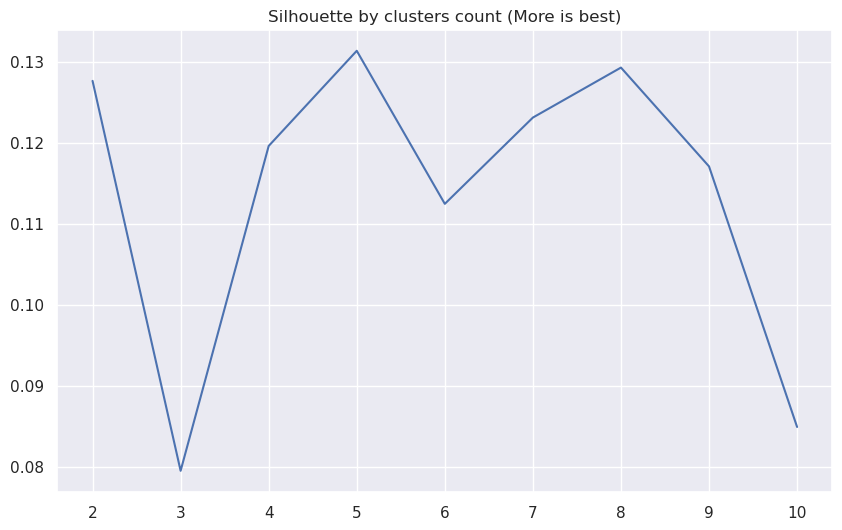

In [13]:
X = model.user_profile.drop('user_id', axis=1)

plot_clustering_metrics(
    X,
    lambda X, k: KMedoids(n_clusters=k, random_state=random_state).fit(X),
    max_clusters=10
)

In [14]:
y = KMedoids(n_clusters=5, random_state=random_state).fit(X).labels_

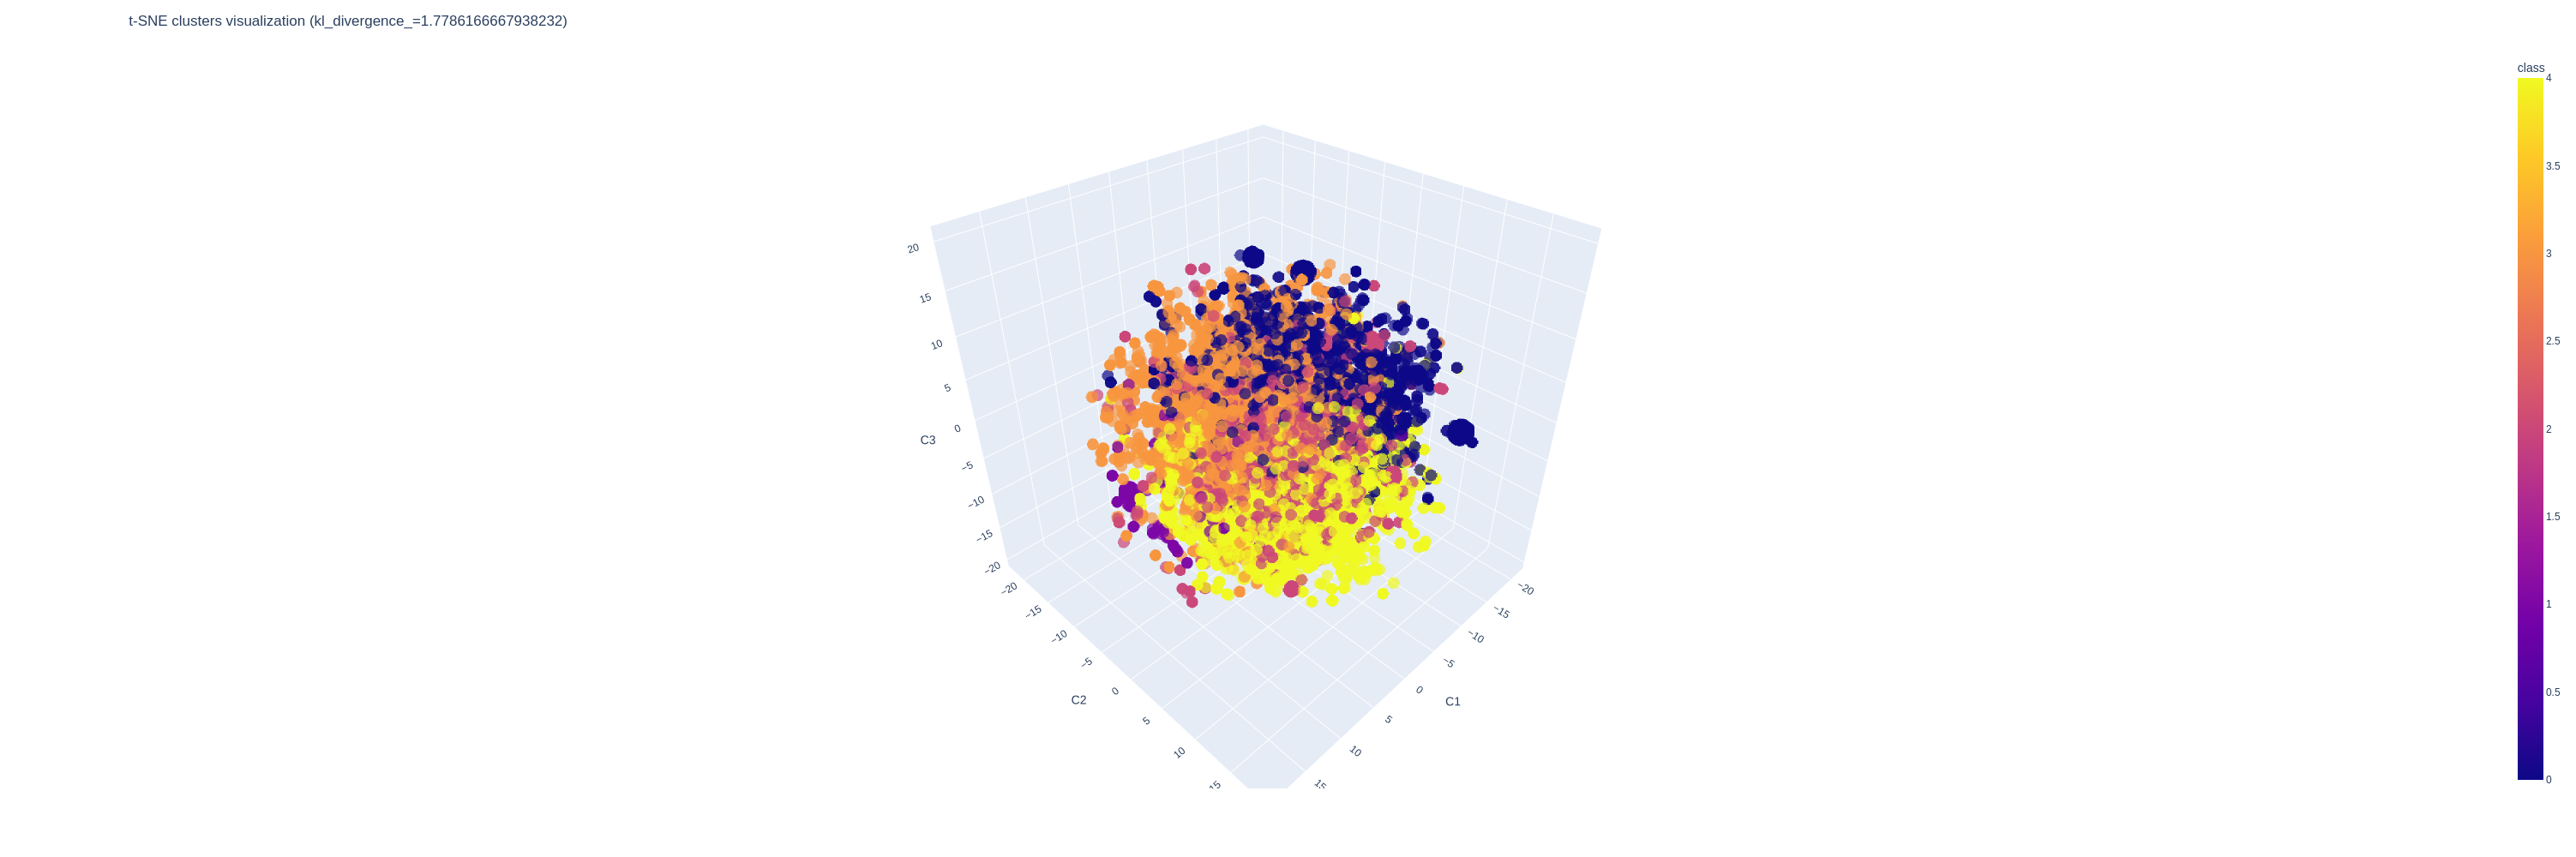

In [15]:
tsne_plot(X, y, random_state=random_state)

In [16]:
user_profile_df = model.user_profile.copy()
user_profile_df['cluster'] = y
user_profile_df = user_profile_df[['user_id', 'cluster']]

data = ds.groupby('user_id', as_index=False)['movie_id'] \
    .count() \
    .rename(columns={'movie_id':'interactions'})

user_profile_df = user_profile_df.merge(data, on=['user_id'])

user_profile_df = user_profile_df.sort_values(['interactions'], ascending=False)

In [17]:
user_profile_df.query('cluster == 0').head(5)

user_id  cluster  interactions
1176     14116        0          1191
10121   126013        0           939
10529   131116        0           509
7514     94026        0           495
6784     84824        0           491

In [26]:
model.recommend(14116).show()


Item Recommender: MultiFeatureUserProfileRecommender



In [18]:
user_profile_df.query('cluster == 1').head(5)

user_id  cluster  interactions
5545     68764        1             8
6615     82556        1             8
10116   125963        1             7
11501   142653        1             6
7625     95295        1             5

In [25]:
model.recommend(68764).show()


Item Recommender: MultiFeatureUserProfileRecommender



In [19]:
user_profile_df.query('cluster == 2').head(5)

user_id  cluster  interactions
10851   135039        2           643
8387    104708        2           548
500       6285        2           502
11368   141166        2           423
1954     24547        2           375

In [24]:
model.recommend(135039).show()


Item Recommender: MultiFeatureUserProfileRecommender



In [20]:
user_profile_df.query('cluster == 3').head(5)

user_id  cluster  interactions
5019     62199        3          3688
520       6550        3          1935
5653     70092        3          1745
1674     21096        3          1361
10554   131347        3          1311

In [23]:
model.recommend(21096).show()


Item Recommender: MultiFeatureUserProfileRecommender



In [21]:
user_profile_df.query('cluster == 4').head(5)

user_id  cluster  interactions
2743    34164        4          1340
2713    33844        4          1079
3873    47969        4           989
8464   105728        4           877
2487    31047        4           828

In [22]:
model.recommend(34164).show()


Item Recommender: MultiFeatureUserProfileRecommender



In [ ]:
model.recommend(21096).show()

In [ ]:
model.recommend(47969).show()

In [ ]:
model.recommend(6038).show()